# Red Wine Flavor Profiles and their Relation to Cost and Quality

**Problem Statement (Hypothesis)**
Is it possible to reverse engineer the most popular or profitable flavor profiles in red wines so that a blend can be characterized that will rate a score above 92 and command a price that is at least 15% higher than the average price for similar blends?

## The Scenario

Our client has access to a number of red wine varietals, but is uncertain which blend of those varietals would produce the highest rated wines and the potential for above average selling prices for the wines produced. They believe that, given a deeper understanding of the connections between flavor profile and price/quality rating, it is possible to create a red wine blend that will be above average in both rated quality and retail selling price. Using data from Wine Enthusiast we will attempt to determine what flavor profiles score highest and have the highest price. The client will be able to use that information to produce a superior wine with a higher than average selling price.

The aim of this project would be to use the combination of rating, prices, and textual reviews to try and answer the question: How does a winery know what flavor profiles to aim for in a given vintage? This could be useful in determining what flavor profiles are popular, and what flavor profiles wineries and winemakers should aim to create if they wish to satisfy current popular trends in red wine flavor profiles. This could not only inform winemakers about which varietals to combine in blends, but could also help inform wineries which varietals to plant, given that they have the proper climate for such varietals (which will not be part of this project).

The criteria for success in this case is defining a minimum of one flavor profile that is shown to increase either the rating of the wine by >=2 points, or increase the price by a minimum of 10%. The scope of this analysis is only red wine varietals, and only those that have received a rating score and a textual review, and have a listed price. In this way we can determine if there is a correlation between the flavor profile characterized by professional wine tasters in the textual review and the rating/price.

While the data does contain 130,000 rows, we might find ourselves constrained by N/A data in the rating, price, or review. It is also possible, though not likely, that the vast majority of the reviews are focused on varietals that don’t fit in our study i.e. white wines or dessert wines. If this is the case we could switch the focus of the study to white wine varietals, but given that red wine made up 46% of wine sales in 2020 and Cabernet Sauvignon is the most popular varietal in the U.S., this shouldn’t be necessary.

The stakeholders could be the owner of a winery, a marketing manager at a winery, the winemaker, the person responsible for sourcing grapes (if they aren’t being grown on-site), and potentially the retail manager if there is also a retail sales area at the winery.

Data sources: This project will use the Kaggle dataset from Wine Enthusiast (https://www.kaggle.com/datasets/zynicide/wine-reviews) includes over 130,000 rows of data and the following features; country, description, designation, #points, price, province/state, region_1, region_2, and the name of the reviewer. This dataset appears to have all the information we will need to conduct this study i.e. description, #points, price. That said, it does not contain a column for the varietal, but that can be extracted from the description through the terms that are used to describe red wines, such as ‘red’, ‘cabernet’, ‘tannin’ and the known flavor characteristics of red wines i.e. ‘blackberry’, ‘plum’, ‘cedar’, etc.

## Table of Contents

1. Sourcing and loading

- Import packages
- Load data
- Explore the data

2. Cleaning and EDA

- Initial visulizations of the data
- Cleaning the data
- Relationship between price and rating
- Analyze word frequencies in the description

3. Feature Engineering

- Extract varietals and important flavor keywords from the descriptions.
- Create a "flavor profile" based on the extracted keywords.

4. Training
- Train/test split

## 1. Sourcing and loading

### 1a. Import Packages

In [1]:
#Importing dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import glob
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

### 1b. Load data

In [2]:
# Find all CSV files in the working directory
csv_files = glob.glob("*.csv")

# Initialize an empty list to store DataFrames
dfs = []

# Loop through all CSV files and read them into DataFrames
for csv_file in csv_files:
    df = pd.read_csv(csv_file, low_memory=False)
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
merged_df = pd.concat(dfs, ignore_index=True)

# Save the merged DataFrame to a new CSV file
merged_df.to_csv("merged.csv", index=False)

print("CSV files have been successfully merged into 'merged.csv'")

# creating a dataframe from the merged data
df = pd.read_csv('C:\\Users\money\Desktop\Springboard\Capstone 2\Capstone-2\merged.csv', low_memory=False)

CSV files have been successfully merged into 'merged.csv'


#### 1c. Explore the data

Exploration entails doing things like checking out the initial appearance of the data with head(), the dimensions of our data with .shape, the data types of the variables with .info(), the number of non-null values, and more to capture the major summary statistics of the data.

In [3]:
#Call the info method on df to see a summary of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280901 entries, 0 to 280900
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             280901 non-null  int64  
 1   country                280833 non-null  object 
 2   description            280901 non-null  object 
 3   designation            197701 non-null  object 
 4   points                 280901 non-null  int64  
 5   price                  258210 non-null  float64
 6   province               280833 non-null  object 
 7   region_1               234594 non-null  object 
 8   region_2               111464 non-null  object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                280900 non-null  object 
 13  winery                 280901 non-null  object 
dtypes: float64(1), int64(2), object(11)


In [4]:
#Call the head method on df to print the first several rows of the data
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [5]:
#Count (using `.sum()`) the number of missing values (`.isnull()`) in each column of 
#df as well as the percentages (using `.mean()` instead of `.sum()`).
#Order them (increasing or decreasing) using sort_values
#Call `pd.concat` to present these in a single table (DataFrame) with the helpful column names 'count' and '%'
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count')

,count,%
Unnamed: 0,0,0.000000
description,0,0.000000
points,0,0.000000
winery,0,0.000000
variety,1,0.000356
country,68,0.024208
province,68,0.024208
price,22691,8.077935
region_1,46307,16.485167
designation,83200,29.618976


There are a number of columns here that are missing a significant amount (> 50%) of data, specifically the title (which is the name and vintage of the wine), region_2 (a secondary designetion of the region where the wine was produced), taster_name (the persone who did the review) and taster_twitter_handle. The designation is also missing nearly 30% of its values, and region_1 is missing more than 16%. The price column, which is critical to answering the business question, is missing roughly 8% of its data. A determination will need to be made, in line with the business problem, if these columns can or should be dropped.

In [6]:
#Let's see if all the entries are unique or if there might be duplicates. We'll use the description 
#label to make that determiniation.
df['description'].value_counts().head()

A little bit funky and unsettled when you pop the screwcap, but soon it finds its floral, blueberry base. Remains superficial and sweet in the mouth, with candied flavors, vanilla and mild oak. Highly regular; could use more concentration and density.    7
A dusty, cigar-smoke character on the nose of this blend of 52% Syrah and 48% Cabernet Sauvignon spices up aromas of strawberry fruit and rotting roses. The palate combines complex cranberry fruits with Kalamata olive, thyme and pencil lead.              6
This is very light, in both flavor and body. The aromas are earthy, with a faint suggestion of blackberries, and the mouthfeel is thin. These aren't terrible flaws, but the wine just lacks substance.                                                        6
92-94 Barrel sample. A rounded wine, its tannins submerged into the ripe fruits. It feels soft, and there is just a bite of alcohol. The structure is soft, generous, opulent.                                                       

It appears that there are many duplicate rows to contend with.

In [7]:
#Are there still duplicates if we take the price column into account?
df1 =  df.astype({'price':'str'})
(df1['price'] + ', ' + df['description']).value_counts().head()

40.0, A dusty, cigar-smoke character on the nose of this blend of 52% Syrah and 48% Cabernet Sauvignon spices up aromas of strawberry fruit and rotting roses. The palate combines complex cranberry fruits with Kalamata olive, thyme and pencil lead.                                                                                                                       6
nan, A fine and impressively complex wine, rich, packed with sultanas and dark chocolate. Very firm, this is worth aging but drinkable now.                                                                                                                                                                                                                                   6
70.0, Possibly just in a sullen phase, this reserve bottling from Craggy's home vineyard is dominated for the moment by smoke and cedar on the nose, and while there is some cherry fruit apparent in the mouth, it doesn't appear to be fully expressing itself. The im

Yes, still many duplicates.

In [8]:
#Because the varietal determines if we are talking about red, white, or dessert wines we need to see 
#the breakdown of varieties.
df['variety'].value_counts()

Pinot Noir                  27563
Chardonnay                  26235
Cabernet Sauvignon          22272
Red Blend                   19008
Bordeaux-style Red Blend    14262
                            ...  
Kotsifali                       1
Petit Courbu                    1
Misket                          1
Babosa Negro                    1
Carnelian                       1
Name: variety, Length: 756, dtype: int64

The data looks to be overwhelmingly red varietals.

In [9]:
#How many different varietals are we actually dealing with?
df['variety'].nunique()

756

In [10]:
#It's also worth looking at the statistics for the points column.

df['points'].describe()

count    280901.000000
mean         88.146934
std           3.151528
min          80.000000
25%          86.000000
50%          88.000000
75%          90.000000
max         100.000000
Name: points, dtype: float64

In [11]:
# Group by 'points' and calculate the count
grouped = df.groupby('points').size().reset_index(name='count')

# Calculate the total number of rows
total_rows = len(df)

# Calculate the percentage of total for each unique value
grouped['%'] = (grouped['count'] / total_rows) * 100

# Sort by 'count' in descending order
grouped = grouped.sort_values(by='count', ascending=False)

# Reset the index and drop the old index
grouped.reset_index(drop=True, inplace=True)

print(grouped)

    points  count          %
0       87  37680  13.413979
1       88  35078  12.487674
2       90  31383  11.172264
3       86  28173  10.029512
4       89  25147   8.952264
5       85  21941   7.810937
6       91  21895   7.794561
7       92  18854   6.711973
8       84  17188   6.118882
9       93  12506   4.452102
10      83   9073   3.229964
11      94   7220   2.570301
12      82   5877   2.092196
13      95   3251   1.157347
14      81   2194   0.781058
15      80   1295   0.461017
16      96   1218   0.433605
17      97    594   0.211462
18      98    208   0.074047
19      99     83   0.029548
20     100     43   0.015308


The most common score given to a wine is 87, followed by 88 and then 90. Given that the mean and median are each 88 this makes sense. It also makes sense to see the five lowest distributions are for the top scores of 96 through 100. Also unsurprising is that the lowest scores of 80 and 81 have relatively few entries. We can also look at this visually to get a better understanding.

<Axes: >

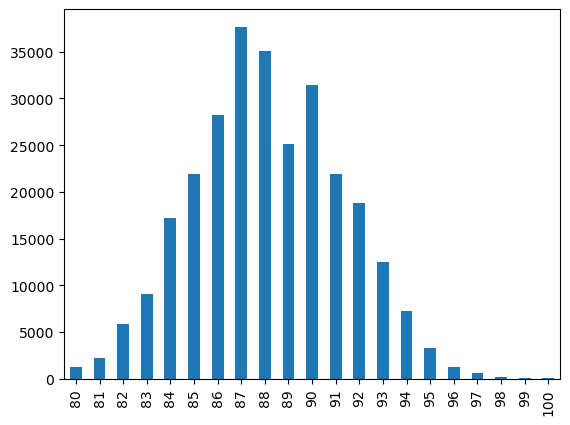

In [12]:
df['points'].value_counts().sort_index().plot.bar()

With the wine dataset, we can group by variety and look at either the summary statistics for all varieties' points and price or select the most popular and expensive ones.

In [13]:
# Groupby by variety
varietal = df.groupby("variety")

# Summary statistic of all varieties
varietal.describe().head()

Unnamed: 0                                                 \
                 count          mean           std      min       25%   
variety                                                                 
Abouriou           3.0  91176.666667  42686.435953  45401.0  71818.00   
Agiorgitiko      183.0  78795.748634  43320.525778    172.0  39709.50   
Aglianico        676.0  64348.621302  38453.232530     72.0  30862.25   
Aidani             2.0  44949.500000   3493.814606  42479.0  43714.25   
Airen              9.0  68056.777778  31279.372647  14295.0  50835.00   

                                          points             ...              \
                 50%        75%       max  count       mean  ...   75%   max   
variety                                                      ...               
Abouriou     98235.0  114064.50  129894.0    3.0  87.666667  ...  89.0  91.0   
Agiorgitiko  81483.0  114550.00  143213.0  183.0  86.016393  ...  88.0  92.0   
Aglianico    68569.5   94559.25  147760.0  676.0  88.933432  ...  91.0  97.0   
Aidani       44949.5   46184.75   47420.0    2.0  82.000000  ...  82.0  82.0   
Airen        56859.0   96459.00  105915.0    9.0  81.444444  ...  83.0  83.0   

             price                                                       
             count       mean        std   min   25%   50%   75%    max  
variety                                                                  
Abouriou       3.0  35.000000  34.641016  15.0  15.0  15.0  45.0   75.0  
Agiorgitiko  180.0  20.794444  11.057845   8.0  13.0  17.0  25.0   66.0  
Aglianico    553.0  36.209765  21.661998   6.0  20.0  30.0  45.0  180.0  
Aidani         2.0  27.000000   0.000000  27.0  27.0  27.0  27.0   27.0  
Airen          9.0   8.888889   0.781736   8.0   8.0   9.0   9.0   10.0  

[5 rows x 24 columns]

This selects the top 5 highest average points among all varieties:

In [14]:
varietal.mean().sort_values(by="points",ascending=False).head()

C:\Users\money\AppData\Local\Temp\ipykernel_14720\361683146.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  varietal.mean().sort_values(by="points",ascending=False).head()


,Unnamed: 0,points,price
variety,,,
Terrantez,31417.0,95.0,236.0
Tinta del Pais,69128.5,95.0,47.5
Riesling-Chardonnay,51348.0,94.0,40.0
Ramisco,107854.0,93.0,495.0
Blauburgunder,17191.5,93.0,19.0


This selects the top 5 highest average prices among all varieties:

In [15]:
varietal.mean().sort_values(by="price",ascending=False).head()

C:\Users\money\AppData\Local\Temp\ipykernel_14720\2014252805.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  varietal.mean().sort_values(by="price",ascending=False).head()


,Unnamed: 0,points,price
variety,,,
Ramisco,107854.000000,93.000000,495.000000
Terrantez,31417.000000,95.000000,236.000000
Francisa,122726.000000,91.000000,160.000000
Rosenmuskateller,32930.000000,92.500000,150.000000
Muscadel,84401.727273,92.454545,131.181818


## 2. Cleaning, and EDA

### 2a. Initial visualization of the data

<Axes: xlabel='points'>

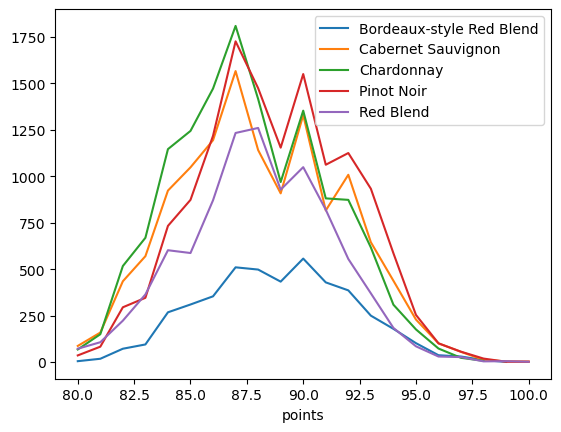

In [16]:
#A visual representation of the points by varietal might be helpful.
#Load a supplemental dataset containing the top five varietals. wine_counts counts the number of times 
#each of the possible review scores was received by the five most commonly reviewed types of wines.
wine_counts = pd.read_csv(r"C:\\Users\money\Desktop\Springboard\Capstone 2\top-five-wine-score-counts.csv", index_col=0)

#Plot the number of times a given number of points was awarded to each varietal.
wine_counts.plot.line()

The above chart shows us the most common scores for each varietal, which varietal has the most of a specific score (for example Chardonnay has the most 87s, but Pinot Noir has the most 90s. The lines also show that the scores fall into a roughly normal distribution.

In [17]:
#What about the price data? Let's look at the statistics around that column.

df['price'].describe()

count    258210.000000
mean         34.177162
std          38.611708
min           4.000000
25%          16.000000
50%          25.000000
75%          40.000000
max        3300.000000
Name: price, dtype: float64

It appears there is a large variation in price, from a minimum of 4 dollars to a maximum of 3300 dollars. It might also be worth noting that the mean is closer to the 75th quartile than the 50th quartile (median). We can look at the data visually as a histogram.

<Axes: ylabel='Frequency'>

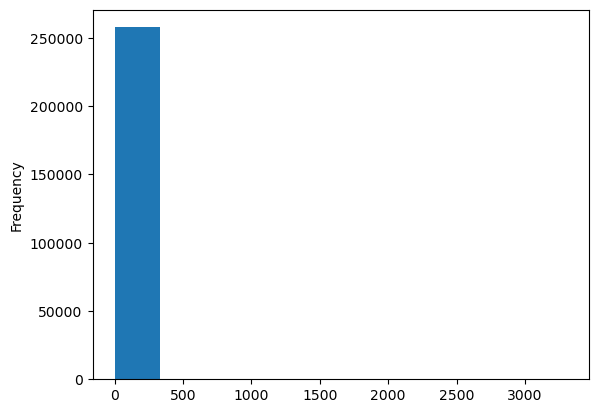

In [18]:
df['price'].plot.hist()

Because there are a number of outliers with very high prices this histogram is skewed. What if we limit the plot to bottles of wine under 100 dollars?

<Axes: ylabel='Frequency'>

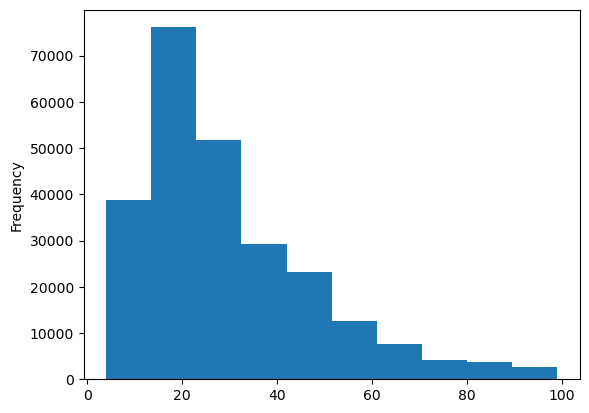

In [19]:
df[df['price'] < 100]['price'].plot.hist()

That looks better. It appears that many of the wines reviewed were in the 20 dollar range.

Let's look at some comparisons between the price and varietal type.

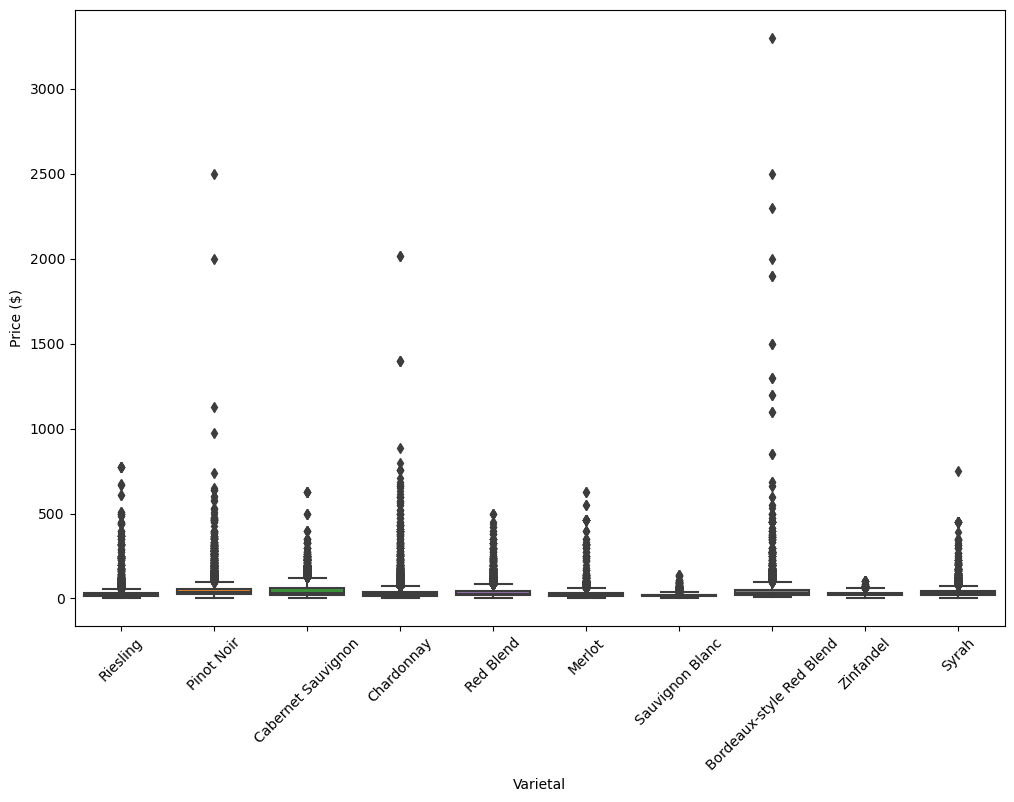

In [20]:
# Count the number of entries for each variety and get the top 10
top_varieties = df['variety'].value_counts().head(10).index.tolist()

# Filter the DataFrame to include only rows where 'variety' is in the list of top 10 varieties
filtered_df = df[df['variety'].isin(top_varieties)]

# Plot the boxplot using the filtered DataFrame
plt.figure(figsize=(12, 8))
sns.boxplot(x='variety', y='price', data=filtered_df)
plt.xticks(rotation=45)  #Rotate x-axis labels for better readability
plt.ylabel('Price ($)')
plt.xlabel('Varietal');

Because there are around 15 outliers that have a price in excess of $1,000 the boxplot isn't very useful. Let's see a boxplot that keeps us within 2 standard deviations of the mean.

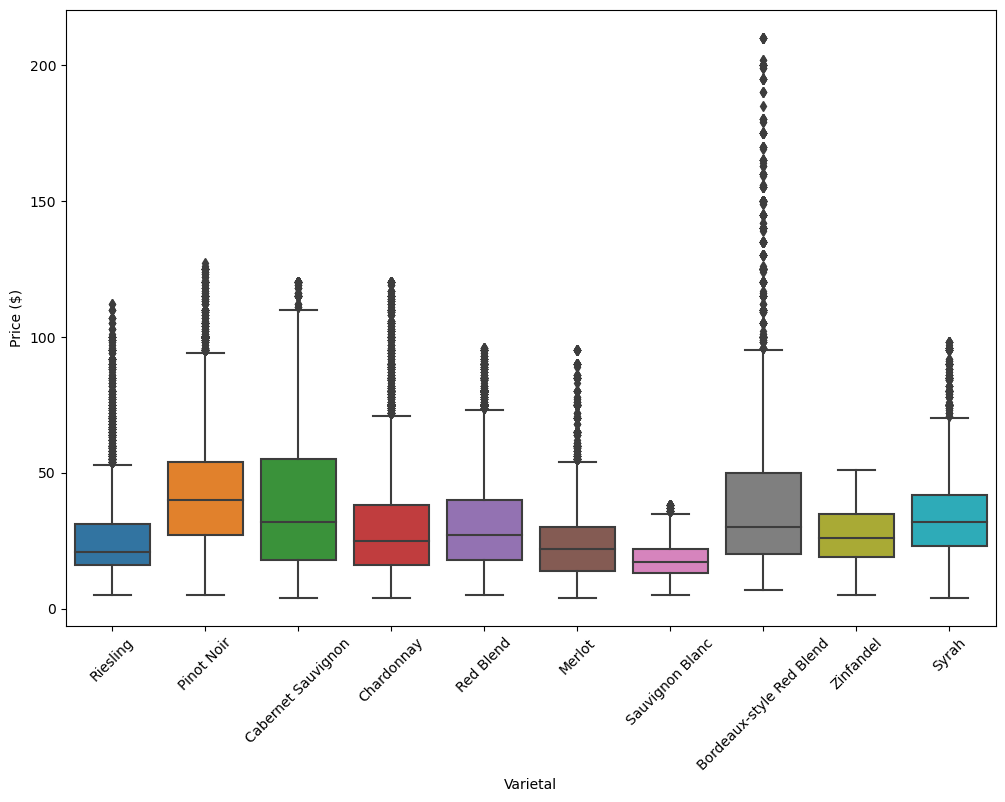

In [21]:
# Count the number of entries for each variety and get the top 10
top_varieties = df['variety'].value_counts().head(10).index.tolist()

# Filter the DataFrame to include only rows where 'variety' is in the list of top 10 varieties
filtered_df = df[df['variety'].isin(top_varieties)]

# Calculate the mean and standard deviation for each group
mean = filtered_df.groupby('variety')['price'].transform('mean')
std = filtered_df.groupby('variety')['price'].transform('std')

# Filter the DataFrame to include only rows where 'price' is within 2 standard deviations of the mean
filtered_df = filtered_df[(filtered_df['price'] >= (mean - 2 * std)) & (filtered_df['price'] <= (mean + 2 * std))]

# Plot the boxplot using the filtered DataFrame
plt.figure(figsize=(12, 8))
sns.boxplot(x='variety', y='price', data=filtered_df)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.ylabel('Price ($)')
plt.xlabel('Varietal');

That gives us an interesting look at the intersection of price and variety. We can see that for these top 10 varieites by count the lowest price is virtually the same. Pinot Noir has the highest mean price, but Bordeaux-style Red Blends have the highest overall price. Sauvignon Blanc has the lowest mean price. Both Chardonnay and Reisling (the other two white varieities in this boxplot) also have mean prices that are below all other varities. This begs the question of whether we might want to focus on red wines only?

Now let's look at some possible correlations between the price and the points.

<Axes: xlabel='price', ylabel='points'>

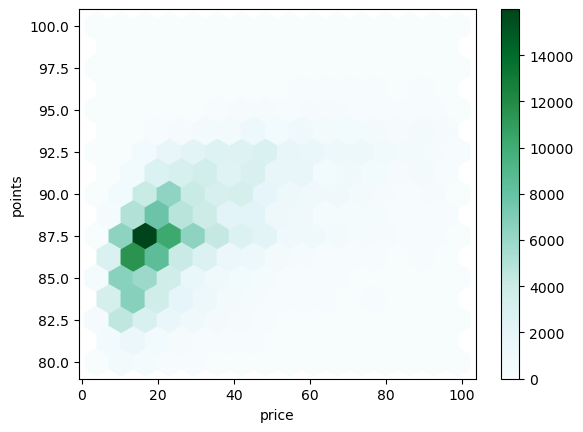

In [22]:
df[df['price'] < 100].plot.hexbin(x='price', y='points', gridsize=15)

We can see from this hexplot that the reviewed bottles of wine cluster around 87.5 points and around 20 dollars, confirming what we saw in our histogram above.

A word cloud can be a useful way to visualize the most important words within the description. Let's start with a simple example: using the first observation description as the input for the word cloud. 

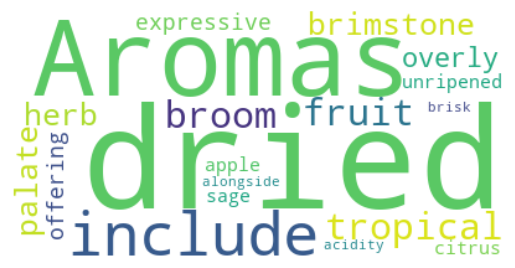

In [23]:
# Start with one review:
text = df.description[0]

# Create and generate a word cloud image:
wordcloud = WordCloud(max_words=100, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Ok, now let's combine all the descriptions to get one huge word cloud that can give us information about the entire dataset of descriptions:

In [24]:
text = " ".join(review for review in df.description)
print ("There are {} words in the combination of all review.".format(len(text)))

There are 68091643 words in the combination of all review.


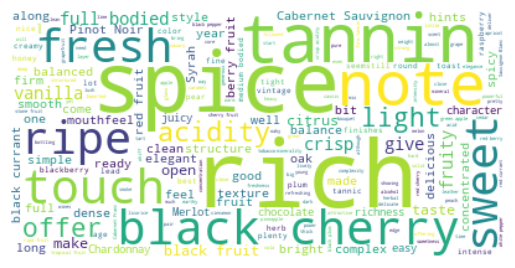

In [25]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["drink", "now", "wine", "flavor", "flavors", "finish", "palate", "hint", "soft", "nose", "show", "dry", "aroma", "mouth", "end", "shows", "blend", "aromas"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The word cloud shows us that there are plenty of descriptors that we can use to look at connections between price and flavors. In the EDA phase we can refine this further through the use of embeddings or transformations.

### 2b. Cleaning the Data

In [26]:
#Filtering the dataset to remove non-red wines
# List of common red wine varieties
red_wine_varieties = [
    'Cabernet Sauvignon', 'Merlot', 'Pinot Noir', 'Syrah', 'Shiraz',
    'Malbec', 'Zinfandel', 'Sangiovese', 'Chianti', 'Tempranillo',
    'Garnacha', 'Red Blend', 'Bordeaux-style Red Blend'
]

# Function to check if a wine is a red wine based on its variety or description
def is_red_wine(row):
    if pd.notnull(row['variety']) and any(variety in row['variety'] for variety in red_wine_varieties):
        return True
    if pd.notnull(row['description']) and any(variety in row['description'] for variety in red_wine_varieties):
        return True
    return False

# Applying the function to filter red wines
df_red_wine = df[df.apply(is_red_wine, axis=1)]

# Dropping rows where the price is missing
df_red_wine = df_red_wine.dropna(subset=['price'])

# Displaying basic information and the first few rows of the cleaned dataset
df_red_wine.info()
df_red_wine.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132532 entries, 4 to 280884
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             132532 non-null  int64  
 1   country                132510 non-null  object 
 2   description            132532 non-null  object 
 3   designation            92729 non-null   object 
 4   points                 132532 non-null  int64  
 5   price                  132532 non-null  float64
 6   province               132510 non-null  object 
 7   region_1               119981 non-null  object 
 8   region_2               70907 non-null   object 
 9   taster_name            46544 non-null   object 
 10  taster_twitter_handle  45618 non-null   object 
 11  title                  60015 non-null   object 
 12  variety                132531 non-null  object 
 13  winery                 132532 non-null  object 
dtypes: float64(1), int64(2), object(11)


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
10,10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature
12,12,US,"Slightly reduced, this wine offers a chalky, t...",NaN,87,34.0,California,Alexander Valley,Sonoma,Virginie Boone,@vboone,Louis M. Martini 2012 Cabernet Sauvignon (Alex...,Cabernet Sauvignon,Louis M. Martini
16,16,Argentina,"Baked plum, molasses, balsamic vinegar and che...",Felix,87,30.0,Other,Cafayate,NaN,Michael Schachner,@wineschach,Felix Lavaque 2010 Felix Malbec (Cafayate),Malbec,Felix Lavaque


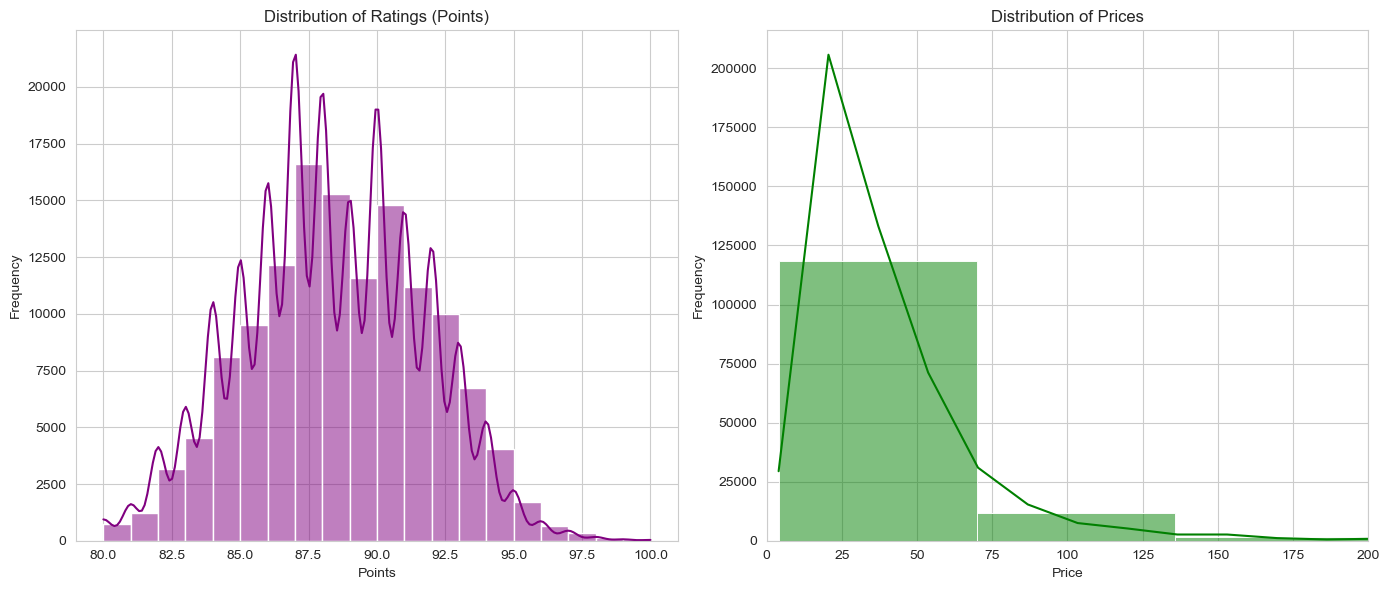

In [27]:
#Distribution of ratings and price after removing non-red wines.
# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

# Creating a figure object
plt.figure(figsize=(14, 6))

# Creating a subplot of 1 row and 2 columns
plt.subplot(1, 2, 1)
sns.histplot(df_red_wine['points'], kde=True, color='purple', bins=20)
plt.title('Distribution of Ratings (Points)')
plt.xlabel('Points')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df_red_wine['price'], kde=True, color='green', bins=50)
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.xlim(0, 200)  # Limiting the x-axis to better visualize the distribution

plt.tight_layout()
plt.show()

**Distribution of Ratings (Points):**
Most wines have a rating between 85 and 90 points, with a peak around 87-88 points.
Few wines have a rating above 95 points, indicating that such high ratings are rare.

**Distribution of Prices:**
A significant majority of wines are priced below $50.
There is a long tail, indicating the presence of some expensive wines, but these are relatively rare.

### 2c. Relationship between price and ratings

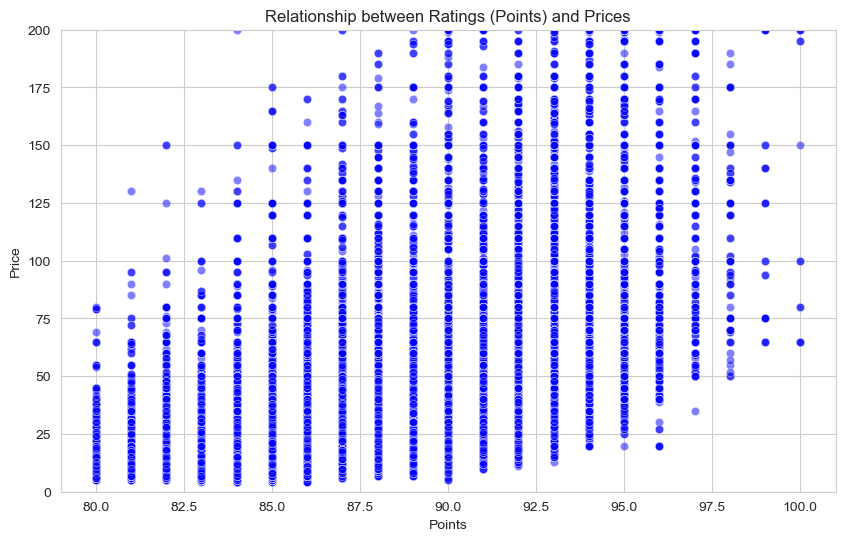

0.440222689523418

In [28]:
# Creating a scatter plot to visualize the relationship between points and price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_red_wine, x='points', y='price', alpha=0.5, color='blue')
plt.title('Relationship between Ratings (Points) and Prices')
plt.xlabel('Points')
plt.ylabel('Price')
plt.ylim(0, 200)  # Limiting the y-axis to better visualize the data points
plt.show()

# Calculating the correlation coefficient between points and price
correlation = df_red_wine['points'].corr(df_red_wine['price'])
correlation

The scatter plot above displays the relationship between the ratings (points) and prices of the red wines. We can observe that there is a positive correlation between the two variables, meaning that wines with higher ratings tend to have higher prices. The correlation coefficient is approximately 0.44, confirming this positive relationship, although it is not extremely strong.

### 2d. Analyze word frequencies in the description

To analyze word frequencies in the descriptions, I will:

**Filter the Wines:**
I will focus on wines with a rating of 92 or higher and prices above the average price. This is because we are looking for descriptions that are correlated with higher prices.

**Preprocess the Descriptions:**
- Convert words to lowercase.
- Remove special characters and numbers.

**Analyze Word Frequencies:**
Identify and visualize the most common words in the descriptions of these selected wines.

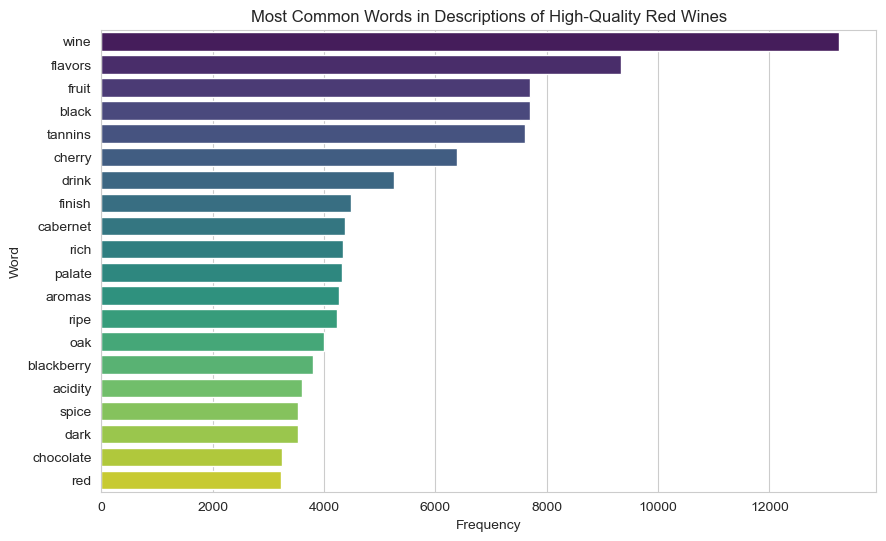

In [29]:
import re
from collections import Counter

# Loading the stopwords
with open(r'C:\Users\money\Desktop\Springboard\Capstone 2\Capstone-2\stopwords-en.txt', errors='ignore') as file:
    custom_stopwords = file.readlines()
    custom_stopwords = [word.strip() for word in custom_stopwords]

# Defining the stopwords set directly using the custom stopwords
stop_words = set(custom_stopwords)
    
# Updating the stopwords set with the custom stopwords
stop_words.update(custom_stopwords)

# Defining the tokenize_description function
def tokenize_description(description):
    # Converting to lowercase
    description = description.lower()
    # Removing special characters and numbers
    description = re.sub(r'[^a-z\s]', '', description)
    # Tokenizing the words
    words = description.split()
    # Removing stopwords
    words = [word for word in words if word not in stop_words]
    return words

# Filtering wines with a rating of 92 or higher and prices above the average price again
high_quality_wines = df_red_wine[(df_red_wine['points'] >= 92) & 
                                  (df_red_wine['price'] > df_red_wine['price'].mean())]

# Tokenizing the descriptions
tokenized_descriptions = high_quality_wines['description'].apply(tokenize_description)

# Calculating word frequencies
word_frequencies = Counter(word for words in tokenized_descriptions for word in words)

# Getting the 20 most common words
common_words = word_frequencies.most_common(20)

# Creating a DataFrame from the common words
common_words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

# Visualizing the most common words again
plt.figure(figsize=(10, 6))
sns.barplot(data=common_words_df, x='Frequency', y='Word', palette='viridis')
plt.title('Most Common Words in Descriptions of High-Quality Red Wines')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

The bar plot displays the most common words found in the descriptions of high-quality red wines (those with ratings of 92 or higher and prices above the average). Words such as "black", "cherry", "tannins", and "fruit" are prevalent, indicating that these might be important characteristics or flavor profiles associated with high-quality red wines.

# 3. Feature Engineering

### 3a. Extracting Flavor Keywords
Extract relevant flavor keywords that are commonly associated with wine tasting.

In [34]:
# Defining flavor keywords

# Reading flavor keywords from the file and stripping any whitespace or newline characters
with open(r"C:\Users\money\Desktop\Springboard\Capstone 2\Capstone-2\wine_flavors.txt") as file:
    flavor_keywords = [keyword.strip() for line in file for keyword in line.split(',')]

# Function to extract flavor keywords from descriptions
def extract_flavors(description):
    flavors = []
    if isinstance(description, str):
        description_lower = description.lower()
        for keyword in flavor_keywords:
            # Using split to consider partial matches within words
            if any(keyword in word for word in description_lower.split()):
                flavors.append(keyword)
    return flavors

# Applying the function to the 'description' column
df_red_wine['flavors'] = df_red_wine['description'].apply(extract_flavors)

# Displaying the DataFrame with the new 'features' column
print(df_red_wine[['flavors']].head(15))

                                         flavors
4                                       [earthy]
5                  [raspberry, blackberry, plum]
10                     [plum, coffee, chocolate]
12                                      [cherry]
16                       [plum, pepper, tobacco]
17                                      [cherry]
18     [blackberry, spice, clove, leather, mint]
19                        [cherry, plum, pepper]
20      [currant, pepper, vanilla, tobacco, tar]
21                              [chocolate, tar]
23             [cherries, plum, plums, licorice]
25         [raspberry, blackberry, spice, smoky]
28                              [vanilla, anise]
33  [currant, currants, spice, spices, licorice]
35                                            []


In [45]:
# Creating a mapping of flavor variations to consolidated names
flavor_mapping = {
    'raspberries': 'raspberry', 'herbs': 'herbs', 'herb': 'herb', 'herbaceous': 'herbaceous', 'blackberries': 'blackberry',
    'earthiness': 'earthy', 'spices': 'spice', 'smoky': 'smoke', 'currants': 'currant',
    'licorice': 'anise', 'cranberries': 'cranberry', 'plums': 'plum', 'raisins': 'raisin',
    'cherries': 'cherry', 'cloves': 'clove', 'prunes': 'prune', 'strawberries': 'strawberry',
    'pomegranates': 'pomegranate', 'figs': 'fig', 'olives': 'olive', 'blueberries': 'blueberry', 'tar': 'tar', 'vanilla': 'vanilla', 
    'leather': 'leather', 'tobacco': 'tobacco', 'pepper': 'pepper', 'chocolate': 'chocolate', 'mint': 'mint', 
    'eucalyptus': 'eucalyptus', 'coffee': 'coffee', 'cassis': 'cassis', 'violet': 'violet', 'minerals': 'minerals', 'mineral': 'mineral', 'cinnamon': 'cinnamon'
}

# Function to consolidate flavor names
def consolidate_flavors(flavors):
    return [flavor_mapping.get(flavor, flavor) for flavor in flavors]

# Applying the function to the 'flavors' column
df_red_wine['consolidated_flavors'] = df_red_wine['flavors'].apply(consolidate_flavors)

# Displaying the DataFrame with the new 'consolidated_flavors' column
print(df_red_wine[['consolidated_flavors']])

                      consolidated_flavors
4                                 [earthy]
5            [raspberry, blackberry, plum]
10               [plum, coffee, chocolate]
12                                [cherry]
16                 [plum, pepper, tobacco]
...                                    ...
280880            [cherry, tobacco, smoke]
280881   [cherry, mineral, chocolate, tar]
280882                            [cherry]
280883                           [tobacco]
280884  [blackberry, anise, smoke, raisin]

[132532 rows x 1 columns]


In [46]:
# Defining the 75th percentile of the price as the threshold for high-priced wines
high_price_threshold = df_red_wine['price'].quantile(0.75)

# Filtering the dataset to include only high-priced wines
high_priced_wines = df_red_wine[df_red_wine['price'] > high_price_threshold]

# Counting the occurrences of each consolidated flavor keyword in the 'consolidated_flavors' column of high-priced wines
flavor_counts_high_priced = Counter(flavor for flavors in high_priced_wines['consolidated_flavors'] for flavor in flavors)

# Converting the counts to a DataFrame for better visualization and sorting by Count
flavor_counts_high_priced_df = pd.DataFrame(flavor_counts_high_priced.items(), columns=['Flavor', 'Count']).sort_values(by='Count', ascending=False)

# Displaying the most common consolidated flavors in high-priced wines
flavor_counts_high_priced_df.head(10)

,Flavor,Count
14,cherry,13559
3,spice,8172
2,blackberry,8008
5,currant,6580
9,plum,5240
20,chocolate,4935
1,raspberry,4193
6,anise,4036
4,smoke,3684
15,pepper,3656


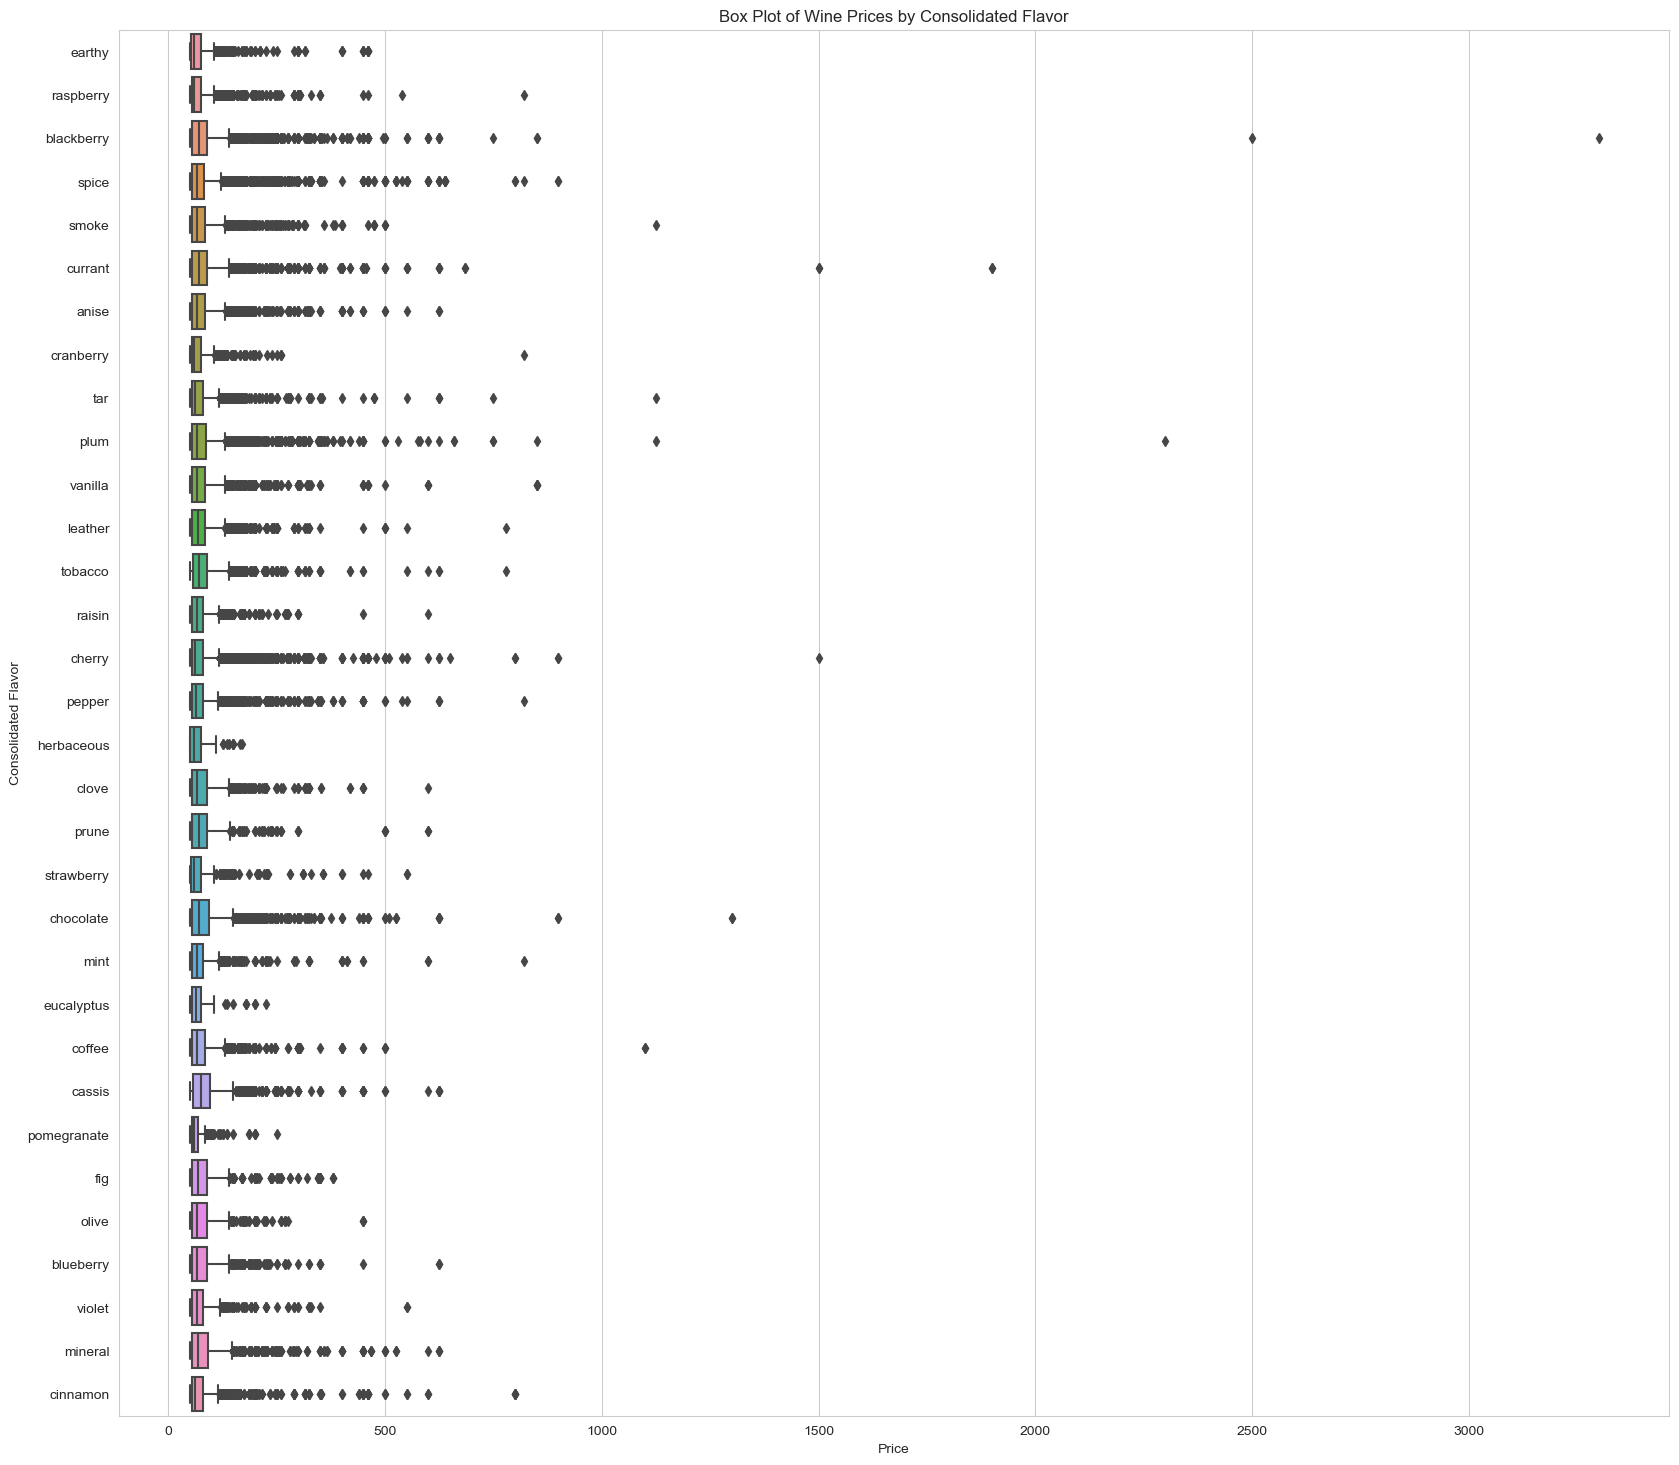

In [47]:
# Creating a DataFrame where each row corresponds to a flavor and a wine's price
flavor_price_data = []
for index, row in high_priced_wines.iterrows():
    for flavor in row['consolidated_flavors']:
        flavor_price_data.append({'Flavor': flavor, 'Price': row['price']})

flavor_price_df = pd.DataFrame(flavor_price_data)

# Creating the box plot
plt.figure(figsize=(20, 18))
sns.boxplot(x='Price', y='Flavor', data=flavor_price_df)
plt.title('Box Plot of Wine Prices by Consolidated Flavor')
plt.xlabel('Price')
plt.ylabel('Consolidated Flavor')
plt.show()

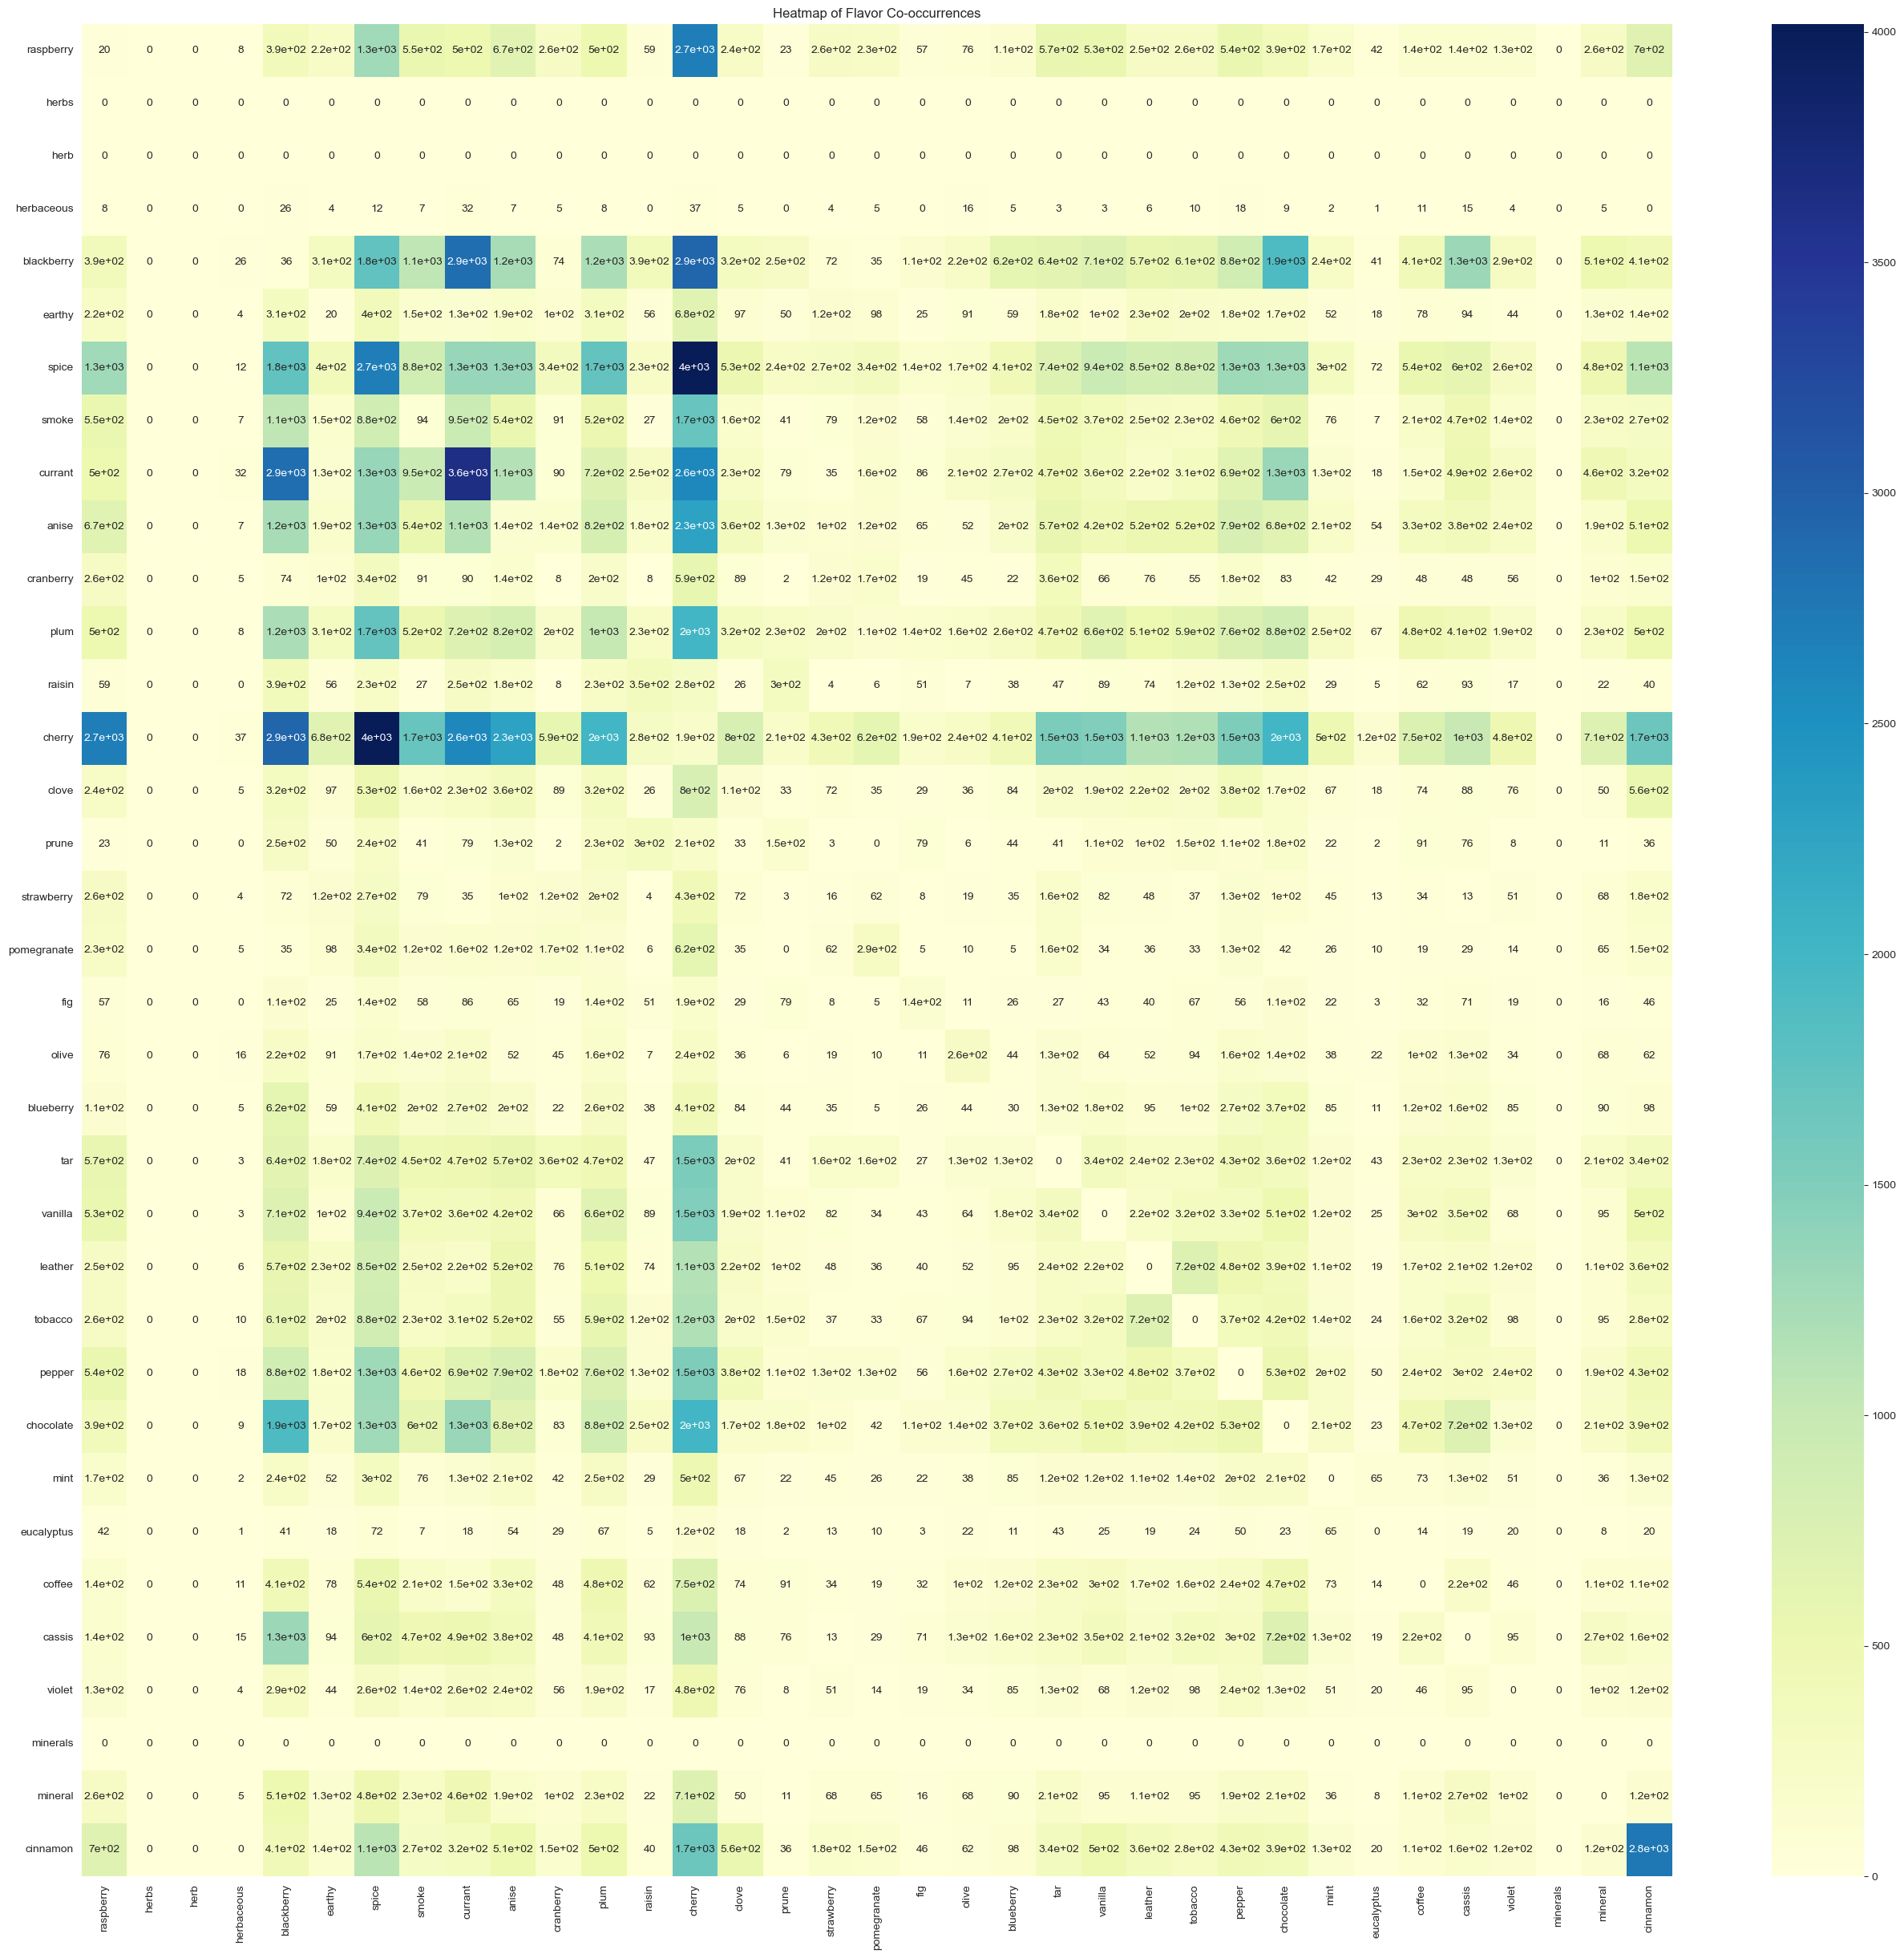

In [48]:
# Creating a DataFrame to track the co-occurrence of flavors
flavor_combinations = pd.DataFrame(index=flavor_mapping.values(), columns=flavor_mapping.values()).fillna(0)
# Remove duplicate rows based on the index
flavor_combinations_no_duplicates = flavor_combinations[~flavor_combinations.index.duplicated(keep='first')]

# Verify if the duplicates are removed
flavor_combinations_no_duplicates.index.duplicated().any(), flavor_combinations_no_duplicates.loc['pepper']

# Function to update the co-occurrence matrix
def update_cooccurrence_matrix(row):
    for i in range(len(row)):
        for j in range(i + 1, len(row)):
            flavor_combinations.at[row[i], row[j]] += 1
            flavor_combinations.at[row[j], row[i]] += 1

# Applying the function to the 'consolidated_flavors' column
high_priced_wines['consolidated_flavors'].apply(update_cooccurrence_matrix)

# Creating the heatmap
plt.figure(figsize=(32, 30))
sns.heatmap(flavor_combinations, cmap='YlGnBu', annot=True)
plt.title('Heatmap of Flavor Co-occurrences')
plt.show()

The above heatmap uncovers several correlated flavor combinations in high priced wines. Examples: cherry and spice, cinnamon and raspberry, blackberry and currant. It also appears that cherry is the flavor that's most often correlated with other flavors in high priced wines.

Finally, let's look at a comparison of these flavors in high-priced versus low-priced wines.

<Figure size 2000x1000 with 0 Axes>

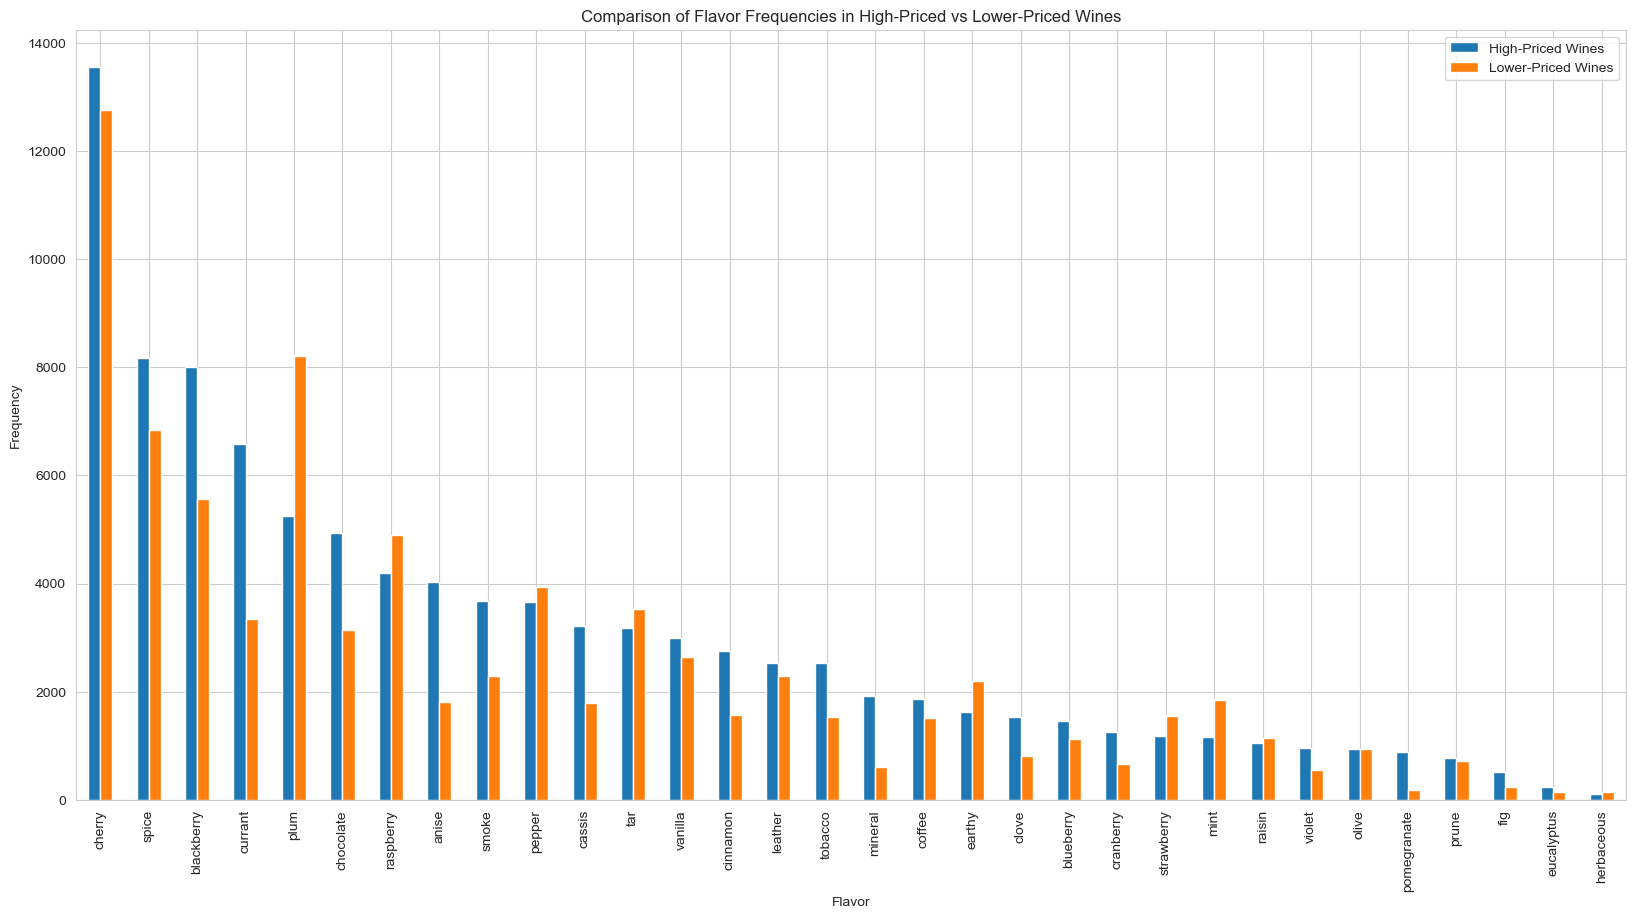

In [49]:
# First, we need to define lower-priced wines. We can consider wines that are below the 25th percentile as lower-priced.
low_price_threshold = df_red_wine['price'].quantile(0.25)
lower_priced_wines = df_red_wine[df_red_wine['price'] <= low_price_threshold]

# Counting the occurrences of each flavor keyword in the 'flavors' column of lower-priced wines
flavor_counts_lower_priced = Counter(flavor for flavors in lower_priced_wines['consolidated_flavors'] for flavor in flavors)

# Converting the counts to a DataFrame for better visualization and sorting by Count
flavor_counts_lower_priced_df = pd.DataFrame(flavor_counts_lower_priced.items(), columns=['Flavor', 'Count']).sort_values(by='Count', ascending=False)

# Now let's combine both high and low priced wine flavor frequencies into a single DataFrame for comparison
flavor_frequencies_comparison = flavor_counts_high_priced_df.set_index('Flavor').join(flavor_counts_lower_priced_df.set_index('Flavor'), lsuffix='_high', rsuffix='_low')

# Fill NaN values with 0, since NaN indicates that the flavor was not found in that price category
flavor_frequencies_comparison = flavor_frequencies_comparison.fillna(0)

# Now let's plot the bar chart
plt.figure(figsize=(20, 10))
flavor_frequencies_comparison.plot(kind='bar', figsize=(20, 10))
plt.title('Comparison of Flavor Frequencies in High-Priced vs Lower-Priced Wines')
plt.ylabel('Frequency')
plt.xlabel('Flavor')
plt.legend(['High-Priced Wines', 'Lower-Priced Wines'])
plt.show()

This is interesting since it shows us some flavors that are more common to higher priced wines. This could help us focus more on these flavors as we create a model to determine the best flavor profiles for higher wine prices. Below we will visualize the top 10 flavors associated with high priced wines to help us with the question of which flavor profiles to examine further.

<Figure size 1600x1200 with 0 Axes>

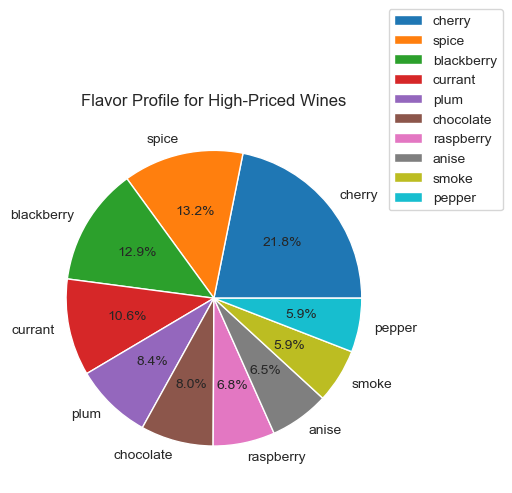

In [50]:
# Plotting a pie chart
# Assume 'flavor_counts_high_priced_df' has the top flavors sorted by frequency
top_flavors = flavor_counts_high_priced_df.head(10)
plt.figure(figsize=(16, 12))
ax = top_flavors.plot.pie(y='Count', labels=top_flavors['Flavor'], autopct='%1.1f%%')
# Remove the y-axis label
ax.set_ylabel('')
plt.title('Flavor Profile for High-Priced Wines')
plt.legend(loc = 'upper right', bbox_to_anchor=(1.3, 1.3))
plt.show()

The pie chart confirms that cherry is the most common flavor found in high-priced red wines. Next we will create a network graph that more clearly shows which flavors are most common in high-priced wines, and the connections between these flavors i.e. which flavors occur most often together.

In [60]:
import networkx as nx

# Reload the flavor_combinations DataFrame from the CSV file
flavor_combinations = pd.read_csv(r"C:\Users\money\Desktop\Springboard\Capstone 2\flavor_combinations.csv", index_col=0)

# Remove duplicate rows based on the index
flavor_combinations_no_duplicates = flavor_combinations[~flavor_combinations.index.duplicated(keep='first')]

# Extract the upper triangle of the matrix, excluding the diagonal
upper_triangle_no_duplicates = pd.DataFrame(np.triu(flavor_combinations_no_duplicates, k=1), 
                                            columns=flavor_combinations_no_duplicates.columns, 
                                            index=flavor_combinations_no_duplicates.index)

# Create a list of edges with weights, only including positive weights using .loc
edges_no_duplicates = [(i, j, upper_triangle_no_duplicates.loc[i, j]) for i in upper_triangle_no_duplicates.index 
                       for j in upper_triangle_no_duplicates.columns if upper_triangle_no_duplicates.loc[i, j] > 0]

edges_no_duplicates[:5]

[('raspberry', 'herbaceous', 624),
 ('raspberry', 'blackberry', 389),
 ('raspberry', 'earthy', 223),
 ('raspberry', 'spice', 1272),
 ('raspberry', 'smoke', 546)]

In [68]:
# Create the graph with no duplicates
G_no_duplicates = nx.Graph()
for edge in edges_no_duplicates:
    G_no_duplicates.add_edge(edge[0], edge[1], weight=edge[2])

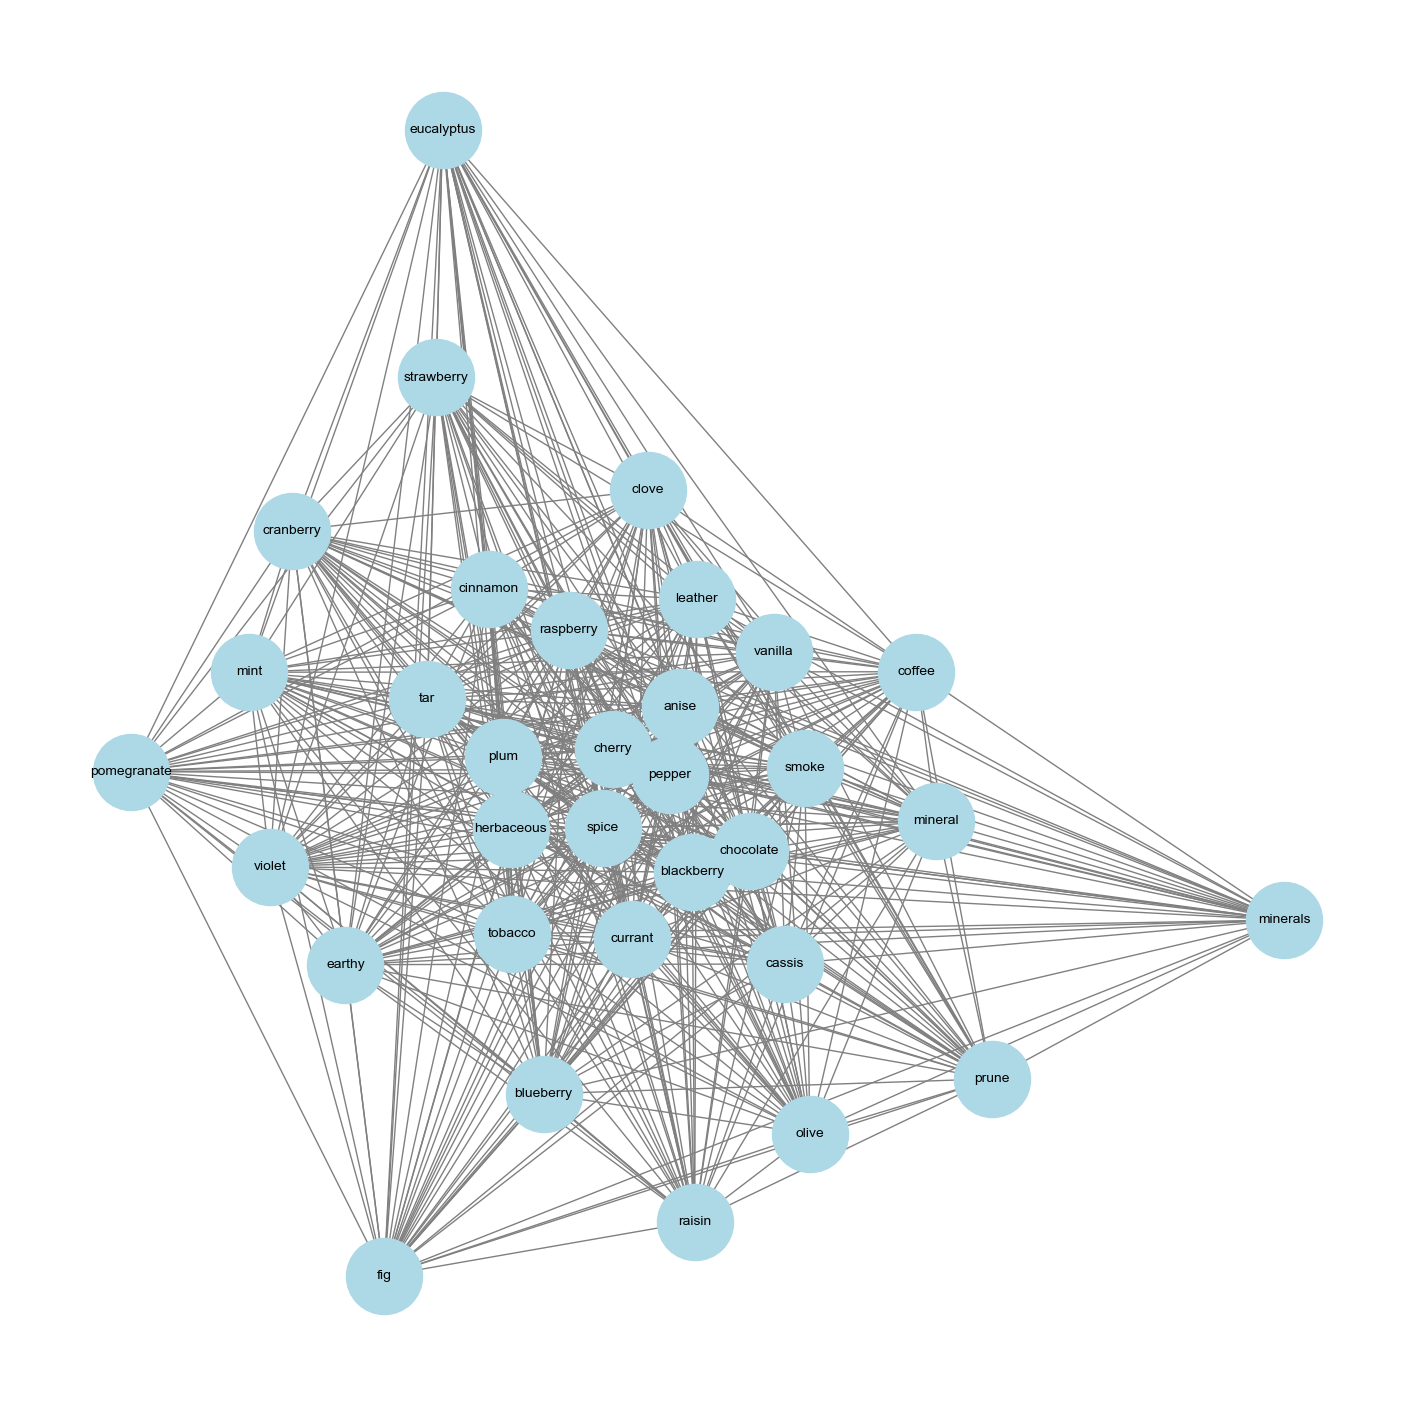

In [67]:
# Calculate the positions of nodes using the spring layout
pos = nx.spring_layout(G_no_duplicates, k=0.5, iterations=50)

# Draw the graph
plt.figure(figsize=(18, 18))
nx.draw_networkx(G_no_duplicates, pos, with_labels=True, node_color='lightblue', 
        edge_color='gray', node_size=3000, font_size=10)
plt.axis('off')
plt.show()